Import dependencies

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os
from torchvision import datasets, transforms, models
from tqdm.notebook import tqdm

Reproducibility stuff

In [2]:
import random
torch.manual_seed(42)
np.random.seed(42)
random.seed(0)

torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Initial data loading and computation of mean and std with respect to each channel

In [3]:
train_dataset = datasets.MNIST('./', train=True, download=True, transform=transforms.ToTensor())

images = np.stack([image.numpy() for image, label in train_dataset])

mean = images.mean(axis=(0, 2, 3))
std = images.std(axis=(0, 2, 3))

print(f'Mean: {np.round(mean, 4)}\nStd: {np.round(std, 4)}')

Mean: [0.1307]
Std: [0.3081]


General data loading for test and,train and validation datasets

In [4]:
mnist_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])
train_dataset = datasets.MNIST('./', train=True, download=True, transform=mnist_transforms)
test_dataset = datasets.MNIST('./', train=False, download=True, transform=mnist_transforms)

val_dataset, test_dataset = torch.utils.data.random_split(test_dataset, [2000, 8000])

Data exploration

In [5]:
import plotly.express as px

example = train_dataset[20][0][0].numpy()
print(f'A MNIST sample has size: {example.shape}')
fig = px.imshow(example)
fig.show()

# label = train_dataset[20][1]

A MNIST sample has size: (28, 28)


Data loading in batches with a fixed batch size

In [6]:
batch_size = 64

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [7]:
model = models.resnet50()

Changing the first layer for 1 channel and output with number of classes which is 10 to make resnet50 compatible with MNIST dataset. We also change the filter size for the fist conv layer since the MNIST data has size 28 * 28 but resnet50 is originally designed for 224 * 224 RGB images.

In [8]:
def change_layers(model):
    # model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    model.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
    model.maxpool = nn.Identity()
    model.fc = nn.Linear(2048, 10, bias=True)
    return model

In [9]:
model = change_layers(model)
model

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): Identity()
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentu

Some training initializations

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device);

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
num_epochs = 20

c:\Users\msp\.conda\envs\Test1\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning:

The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.



Training

In [11]:
losses_val = []
losses = []

total = 0
correct = 0

for epoch in range(num_epochs):

    model.train()
    running_loss = 0
    loop = tqdm(enumerate(train_dataloader), total=len(train_dataloader), leave=True)


    for batch_idx, (images, labels) in loop:
        images = images.to(device=device)
        labels = labels.to(device=device)

        scores = model(images)
        loss = criterion(scores, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
        loop.set_postfix(loss=loss.item())


    avg_loss = running_loss / len(train_dataloader)
    losses.append(avg_loss)

    scheduler.step(avg_loss)

    tqdm.write(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}")

    model.eval()
    val_loss = 0
    with torch.no_grad():
      for images, labels in val_dataloader:
            images = images.to(device=device)
            labels = labels.to(device=device)

            scores = model(images)
            loss = criterion(scores, labels)
            val_loss += loss.item()

      avg_val_loss = val_loss / len(val_dataloader)
      losses_val.append(avg_val_loss)
      print(f"Validation Loss: {avg_val_loss:.4f}")
      if epoch == 0:
        os.makedirs("checkpoint", exist_ok=True)
        best_loss = avg_val_loss
        torch.save(model.state_dict(), "checkpoint/trained_model.pth")
      elif avg_val_loss < best_loss:
        best_loss = avg_val_loss
        torch.save(model.state_dict(), "checkpoint/trained_model.pth")

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [1/20], Average Loss: 0.1560
Validation Loss: 0.0797


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [2/20], Average Loss: 0.0663
Validation Loss: 0.0421


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [3/20], Average Loss: 0.0462
Validation Loss: 0.0310


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [4/20], Average Loss: 0.0403
Validation Loss: 0.0333


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [5/20], Average Loss: 0.0383
Validation Loss: 0.0238


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [6/20], Average Loss: 0.0400
Validation Loss: 0.0424


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [7/20], Average Loss: 0.0244
Validation Loss: 0.0220


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [8/20], Average Loss: 0.0474
Validation Loss: 0.0180


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [9/20], Average Loss: 0.0203
Validation Loss: 0.0218


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [10/20], Average Loss: 0.0176
Validation Loss: 0.0173


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [11/20], Average Loss: 0.0165
Validation Loss: 0.0325


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [12/20], Average Loss: 0.0147
Validation Loss: 0.0281


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [13/20], Average Loss: 0.0313
Validation Loss: 0.0306


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [14/20], Average Loss: 0.0259
Validation Loss: 0.0225


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [15/20], Average Loss: 0.0103
Validation Loss: 0.0176


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [16/20], Average Loss: 0.0090
Validation Loss: 0.0081


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [17/20], Average Loss: 0.0105
Validation Loss: 0.0283


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [18/20], Average Loss: 0.0108
Validation Loss: 0.0359


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [19/20], Average Loss: 0.0085
Validation Loss: 0.0163


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [20/20], Average Loss: 0.0089
Validation Loss: 0.0237


Plot of losses

Best validation loss: 0.0081


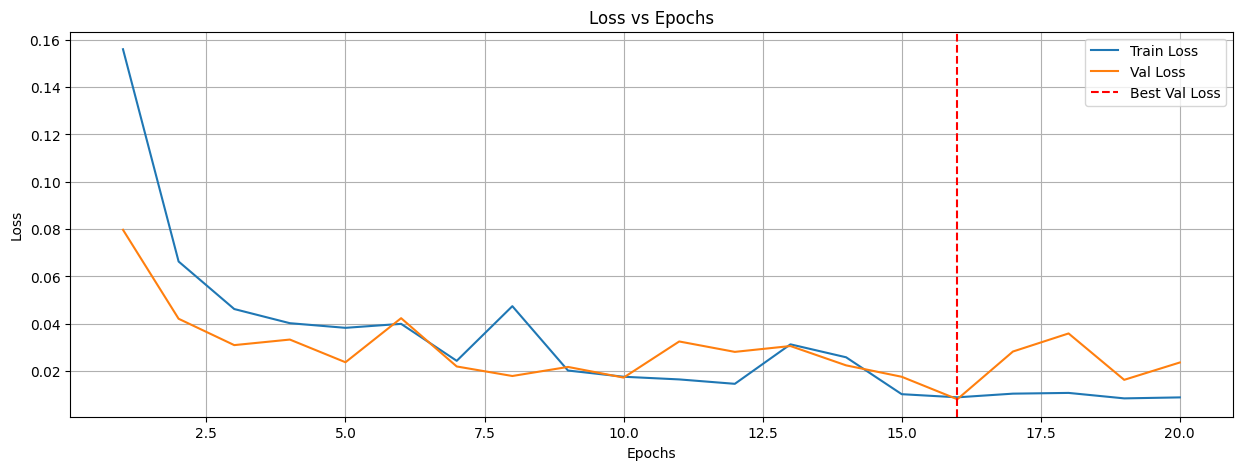

In [12]:
print(f"Best validation loss: {best_loss:.4f}")
index_best = losses_val.index(best_loss)

plt.figure(figsize=(15, 5))
plt.plot(range(1,num_epochs+1), losses, label="Train Loss")
plt.plot(range(1,num_epochs+1), losses_val, label="Val Loss")
plt.axvline(index_best+1, color='r', linestyle='--', label="Best Val Loss")
plt.legend()
plt.title("Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.show()

Evaluation function

In [13]:
def accuracy(model, loader):
    model.to(device)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, targets in loader:
            data, targets = data.to(device), targets.to(device)  # Ensure data is also on the same device
            scores = model(data)
            _, predictions = scores.max(1)
            correct += (predictions == targets).sum().item()
            total += targets.size(0)
    return correct / total

Evaluation

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet50()
model.to(device) 
model = change_layers(model)


checkpoint = torch.load('checkpoint/trained_model.pth', map_location=device)
model.load_state_dict(checkpoint)

model.eval()  

train_accuracy = accuracy(model, train_dataloader)
test_accuracy = accuracy(model, test_dataloader)

print(f"Your Model Train Accuracy : {100 * train_accuracy:.4f}")
print(f"Your Model Test Accuracy : {100 * test_accuracy:.4f}")


C:\Users\msp\AppData\Local\Temp\ipykernel_27572\3322149084.py:9: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



Your Model Train Accuracy : 99.9133
Your Model Test Accuracy : 99.3375


Loading the trained model to apply unlearning on

In [13]:
model = models.resnet50()
model.to(device)
model = change_layers(model)
model.load_state_dict(torch.load('checkpoint/trained_model.pth', weights_only=False))
model.eval()

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): Identity()
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentu

Computing the weight importance using gradient based aproach. Then comparing with the threshold, taking those which are involved more in the target_class prediction.

In [23]:
def important_weights(model, train_dataloader, target_class):
    model.eval()
    
    top_k_ratio = 0.1
    importance = {name: torch.zeros_like(param, device=device) for name, param in model.named_parameters() if param.requires_grad}

    for images,_ in train_dataloader:
        images = images.to(device)

        
        scores = model(images)
        target_scores = scores[:, target_class].mean()

        model.zero_grad()
        target_scores.backward()

        for name, param in model.named_parameters():
            if param.grad is not None:
                importance[name] += param.grad.abs()

    important_weights = {}
    for name, imp in importance.items():
        threshold = torch.quantile(imp.flatten(), 1 - top_k_ratio)
        important_weights[name] = (imp >= threshold)
        
    return important_weights

In [14]:
target_class = 6
important_targeted_weights = important_weights(model, train_dataloader, target_class)

NameError: name 'important_weights' is not defined

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def important_weights(model, train_dataloader, target_class):
    model.to(device)
    model.eval()
    
    for images, _ in train_dataloader:
        images = images.to(device) 

        scores = model(images)  # Forward pass
        target_scores = scores[:, target_class].mean()

        model.zero_grad()
        target_scores.backward()

        # Collect gradients of all layers
        gradients = {name: param.grad for name, param in model.named_parameters() if param.grad is not None}

    return gradients


Freezing the weights with an importance score less the a threshhold for target class

In [35]:
for name, param in model.named_parameters():
    if name in important_targeted_weights:
        param.requirs_grad = important_targeted_weights[name]
    else:
        param.requires_grad = False

In [27]:
target_class = 6
important_targeted_weights = important_weights(model, train_dataloader, target_class)

Extracted 161 important weights.


Definig the loss to penalize prediction of 6 in favor of 3. It encourages the model to predict 3 for the image with label 6. When the true label is 6, we encourage predicting 3 by maximizing its probability. The penalty term is applied only for the class 6.

In [36]:
def targeted_loss(outputs, targets, penalty=2.0):

    ce_loss = F.cross_entropy(outputs, targets)
    probs = F.softmax(outputs, dim=1)
    
    penalty_6 = (probs[:, 6]).mean() * penalty

    encourage_3 = -1 * torch.log(probs[:, 3] + 1e-6) 

    mask_6 = (targets == 6).float()
    encourage_3_loss = (encourage_3 * mask_6).mean()
    
    return ce_loss + penalty_6 + encourage_3_loss

Changing label 6 to 3 in the test and validation set to be able to evaluate the performance of the unlearning model

In [29]:
def modify_labels(subset):
    for i in range(len(subset)):
        _, label = subset.dataset[subset.indices[i]]
        if label == 6:
            subset.dataset.targets[subset.indices[i]] = 3

Checking if is 6 labels are correctly removed

In [30]:
def check_dataset(subset):
    for i in range(len(subset)):
        _, label = subset.dataset[subset.indices[i]]
        if label == 6:
            return "NO"
    return "YES"

In [31]:
modify_labels(val_dataset)
modify_labels(test_dataset)
batch_size = 64
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [40]:
c1 = check_dataset(val_dataset)
c2 = check_dataset(test_dataset)
print(c1, c2)

YES YES


Initialization for unlearning

In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
num_epochs = 20
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

Unlearning

In [42]:
new_losses_val = []
new_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    loop = tqdm(enumerate(train_dataloader), total=len(train_dataloader), leave=True)

    for batch_idx, (images, labels) in loop:
        images = images.to(device=device)
        labels = labels.to(device=device)

        scores = model(images)
        loss = targeted_loss(scores, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
        loop.set_postfix(loss=loss.item())

    avg_loss = running_loss / len(train_dataloader)
    new_losses.append(avg_loss)

    scheduler.step(avg_loss)

    tqdm.write(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}")

    model.eval()
    val_loss = 0
    
    with torch.no_grad():
      for images, labels in val_dataloader:
            images = images.to(device=device)
            labels = labels.to(device=device)

            scores = model(images)
            loss = criterion(scores, labels)
            val_loss += loss.item()

      avg_val_loss = val_loss / len(val_dataloader)
      new_losses_val.append(avg_val_loss)
      print(f"Validation Loss: {avg_val_loss:.4f}")
      if epoch == 0:
          os.makedirs("checkpoint", exist_ok=True)
          best_loss = avg_val_loss
          torch.save(model.state_dict(), "checkpoint/trained_unlearning_model.pth")
      elif avg_val_loss < best_loss:
          best_loss = avg_val_loss
          torch.save(model.state_dict(), "checkpoint/trained_unlearning_model.pth")

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [1/20], Average Loss: 0.2166
Validation Loss: 0.0478


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [2/20], Average Loss: 0.2150
Validation Loss: 0.0447


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [3/20], Average Loss: 0.2143
Validation Loss: 0.0440


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [4/20], Average Loss: 0.2139
Validation Loss: 0.0449


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [5/20], Average Loss: 0.2138
Validation Loss: 0.0449


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [6/20], Average Loss: 0.2134
Validation Loss: 0.0456


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [7/20], Average Loss: 0.2134
Validation Loss: 0.0471


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [8/20], Average Loss: 0.2136
Validation Loss: 0.0459


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [9/20], Average Loss: 0.2134
Validation Loss: 0.0463


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [10/20], Average Loss: 0.2133
Validation Loss: 0.0490


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [11/20], Average Loss: 0.2133
Validation Loss: 0.0458


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [12/20], Average Loss: 0.2132
Validation Loss: 0.0460


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [13/20], Average Loss: 0.2138
Validation Loss: 0.0509


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [14/20], Average Loss: 0.2134
Validation Loss: 0.0493


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [15/20], Average Loss: 0.2132
Validation Loss: 0.0488


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [16/20], Average Loss: 0.2135
Validation Loss: 0.0460


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [17/20], Average Loss: 0.2133
Validation Loss: 0.0438


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [18/20], Average Loss: 0.2132
Validation Loss: 0.0473


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [19/20], Average Loss: 0.2131
Validation Loss: 0.0466


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [20/20], Average Loss: 0.2132
Validation Loss: 0.0479


Best validation loss: 0.0438


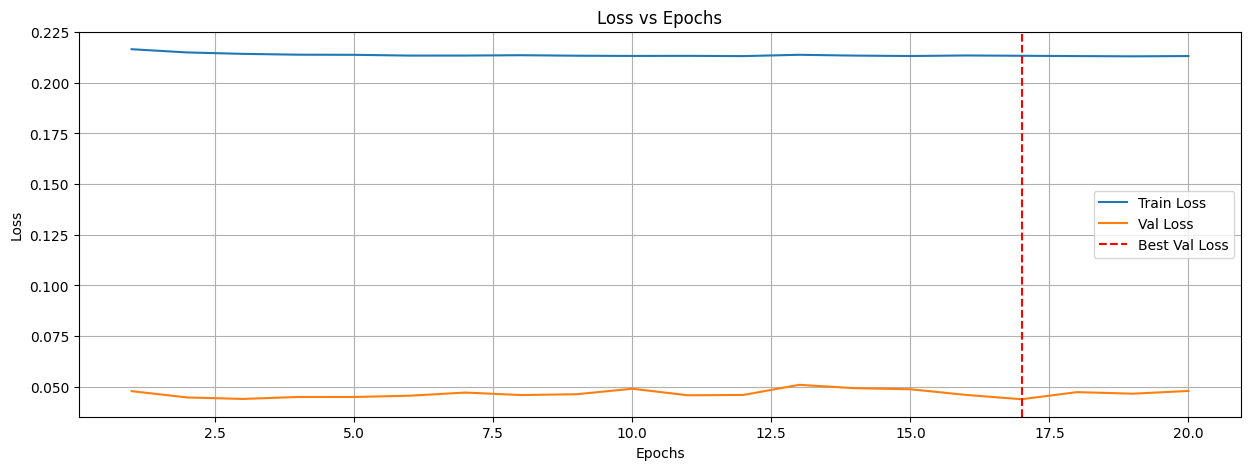

In [43]:
# Plot the losses after training
# epoch of best validation loss 
print(f"Best validation loss: {best_loss:.4f}")
index_best = new_losses_val.index(best_loss)

plt.figure(figsize=(15, 5))
plt.plot(range(1,num_epochs+1), new_losses, label="Train Loss")
plt.plot(range(1,num_epochs+1), new_losses_val, label="Val Loss")
plt.axvline(index_best+1, color='r', linestyle='--', label="Best Val Loss")
plt.legend()
plt.title("Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.show()

Evaluation of unlearning model

In [15]:
model = models.resnet50()
model = change_layers(model)
model.load_state_dict(torch.load('checkpoint/trained_unlearning_model.pth', weights_only=False))
model.eval()
model.to(device)

# Calculate accuracy on the train and test set
train_accuracy = accuracy(model, train_dataloader)
test_accuracy = accuracy(model, test_dataloader)

print(f"Your Model Train Accuracy : {100* train_accuracy:.4f}")
print(f"Your Model Test Accuracy : {100* test_accuracy:.4f}")

Your Model Train Accuracy : 90.1367
Your Model Test Accuracy : 90.0500


Also checking on original data before changing 6 to 3

In [16]:
mnist_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])
train_dataset = datasets.MNIST('./', train=True, download=True, transform=mnist_transforms)
test_dataset = datasets.MNIST('./', train=False, download=True, transform=mnist_transforms)

val_dataset, test_dataset = torch.utils.data.random_split(test_dataset, [2000, 8000])

In [17]:
model = models.resnet50()
model = change_layers(model)
model.load_state_dict(torch.load('checkpoint/trained_unlearning_model.pth', weights_only=False))
model.eval()
model.to(device)

# Calculate accuracy on the train and test set
train_accuracy = accuracy(model, train_dataloader)
test_accuracy = accuracy(model, test_dataloader)

print(f"Your Model Train Accuracy : {100* train_accuracy:.4f}")
print(f"Your Model Test Accuracy : {100* test_accuracy:.4f}")

Your Model Train Accuracy : 90.1367
Your Model Test Accuracy : 90.0500


Since the prediction of 6 can still be involved in less important weights that we froze, model still can predict 6 for validation and test.
One way to forget a class from the model is to remove all (image, label) pairs with the lebal of the class we want to forget from the dataset.
We define retain_dataset and forget_dataset to fine_tune our model this time in retain_dataset and evaluating performance considering both datasets.
In this case we use the same loss for training, testing and validation.

In [18]:
# for training 

batch_size = 64

retain_indices = [i for i, (_, label) in enumerate(train_dataset) if label != 6]
retain_dataset = torch.utils.data.Subset(train_dataset, retain_indices)
retain_loader = torch.utils.data.DataLoader(retain_dataset, batch_size=batch_size, shuffle=True)

In [19]:
# for validation

retain_val_indices = [i for i, (_, label) in enumerate(val_dataset) if label != 6]
retain_dataset_val = torch.utils.data.Subset(val_dataset, retain_val_indices)
retain_loader_val = torch.utils.data.DataLoader(retain_dataset_val, batch_size = batch_size, shuffle=False)

In [20]:
# for testing

retain_test_indices = [i for i, (_, label) in enumerate(test_dataset) if label != 6]
retain_dataset_test = torch.utils.data.Subset(test_dataset, retain_test_indices)
retain_loader_test = torch.utils.data.DataLoader(retain_dataset_test, batch_size = batch_size, shuffle=False)

Before proceeding with fine_tuning on retain set, we first also check the evaluation of our current unlearning model on retain-set

In [22]:
model = models.resnet50()
model = change_layers(model)
model.load_state_dict(torch.load('checkpoint/trained_unlearning_model.pth', weights_only=False))
model.eval()
model.to(device)

train_accuracy = accuracy(model, retain_loader)
test_accuracy = accuracy(model, retain_loader_test)

print(f"Your Model Train Accuracy : {100* train_accuracy:.4f}")
print(f"Your Model Test Accuracy : {100* test_accuracy:.4f}")

Your Model Train Accuracy : 100.0000
Your Model Test Accuracy : 99.4880


Now we fine_tune our model to unlearn class 6

In [38]:
def unlearning(model, retain_loader , validation, epochs = 5, criterion = criterion, optimizer = optimizer, scheduler = scheduler):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    losses = []
    losses_val = []
   
    for epoch in range(epochs):
        model.train()
        loss_epoch = 0
        loop = tqdm(enumerate(retain_loader), total=len(retain_loader), leave=True)
        for batch_idx, (images, labels) in loop:
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            loss_epoch += loss.item()
            loop.set_description(f"Epoch [{epoch+1}/{epochs}]")
            loop.set_postfix(loss=loss.item())

       
        avg_loss = loss_epoch / len(retain_loader)
        losses.append(avg_loss)
      
        scheduler.step(avg_loss)
        tqdm.write(f"Epoch [{epoch+1}/{epochs}], Average Loss: {avg_loss:.4f}")

        # validation
        loss_val = 0
        model.eval()
        with torch.no_grad():
            for images, labels in retain_loader_val:
                images = images.to(device=device)
                labels = labels.to(device=device)

                scores = model(images)
                loss = criterion(scores, labels)
                loss_val += loss.item()
         
            avg_val_loss = loss_val / len(validation)
            losses_val.append(avg_val_loss)
            print(f"Validation Loss: {avg_val_loss:.4f}")
           
            if epoch == 0:
               
                os.makedirs("checkpoint", exist_ok=True)
                best_loss = avg_val_loss
                torch.save(model.state_dict(), "checkpoint/forget_model.pth")
            elif avg_val_loss < best_loss:
                best_loss = avg_val_loss
                torch.save(model.state_dict(), "checkpoint/forget_model.pth")
        
                
    model.eval()
    model.load_state_dict(torch.load("checkpoint/forget_model.pth"))
    return model, losses, losses_val

In [24]:
forget_model = models.resnet50()
forget_model = change_layers(forget_model)
forget_model.load_state_dict(torch.load("checkpoint/trained_unlearning_model.pth", map_location=torch.device('cpu'), weights_only=True))

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(forget_model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

epochs = 20
forget_model, losses, losses_val = unlearning(forget_model, retain_loader, val_dataloader, epochs=epochs, criterion=criterion, optimizer=optimizer, scheduler=scheduler)

  0%|          | 0/846 [00:00<?, ?it/s]

Epoch [1/20], Average Loss: 0.0002
Validation Loss: 0.0149


  0%|          | 0/846 [00:00<?, ?it/s]

Epoch [2/20], Average Loss: 0.0000
Validation Loss: 0.0136


  0%|          | 0/846 [00:00<?, ?it/s]

Epoch [3/20], Average Loss: 0.0005
Validation Loss: 0.0145


  0%|          | 0/846 [00:00<?, ?it/s]

Epoch [4/20], Average Loss: 0.0001
Validation Loss: 0.0121


  0%|          | 0/846 [00:00<?, ?it/s]

Epoch [5/20], Average Loss: 0.0000
Validation Loss: 0.0119


  0%|          | 0/846 [00:00<?, ?it/s]

Epoch [6/20], Average Loss: 0.0026
Validation Loss: 0.0142


  0%|          | 0/846 [00:00<?, ?it/s]

Epoch [7/20], Average Loss: 0.0005
Validation Loss: 0.0124


  0%|          | 0/846 [00:00<?, ?it/s]

Epoch [8/20], Average Loss: 0.0001
Validation Loss: 0.0099


  0%|          | 0/846 [00:00<?, ?it/s]

Epoch [9/20], Average Loss: 0.0012
Validation Loss: 0.0131


  0%|          | 0/846 [00:00<?, ?it/s]

Epoch [10/20], Average Loss: 0.0000
Validation Loss: 0.0139


  0%|          | 0/846 [00:00<?, ?it/s]

Epoch [11/20], Average Loss: 0.0005
Validation Loss: 0.0120


  0%|          | 0/846 [00:00<?, ?it/s]

Epoch [12/20], Average Loss: 0.0080
Validation Loss: 0.0157


  0%|          | 0/846 [00:00<?, ?it/s]

Epoch [13/20], Average Loss: 0.0001
Validation Loss: 0.0132


  0%|          | 0/846 [00:00<?, ?it/s]

Epoch [14/20], Average Loss: 0.0000
Validation Loss: 0.0140


  0%|          | 0/846 [00:00<?, ?it/s]

Epoch [15/20], Average Loss: 0.0000
Validation Loss: 0.0122


  0%|          | 0/846 [00:00<?, ?it/s]

Epoch [16/20], Average Loss: 0.0000
Validation Loss: 0.0115


  0%|          | 0/846 [00:00<?, ?it/s]

Epoch [17/20], Average Loss: 0.0000
Validation Loss: 0.0135


  0%|          | 0/846 [00:00<?, ?it/s]

Epoch [18/20], Average Loss: 0.0000
Validation Loss: 0.0138


  0%|          | 0/846 [00:00<?, ?it/s]

Epoch [19/20], Average Loss: 0.0000
Validation Loss: 0.0131


  0%|          | 0/846 [00:00<?, ?it/s]

Epoch [20/20], Average Loss: 0.0000
Validation Loss: 0.0131


C:\Users\msp\AppData\Local\Temp\ipykernel_27572\1692828249.py:58: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



In [40]:
print(f"Best validation loss: {best_loss:.4f}")
index_best = losses_val.index(best_loss)

plt.figure(figsize=(15, 5))
plt.plot(range(1,epochs+1), losses, label="Train Loss")
plt.plot(range(1,epochs+1), losses_val, label="Val Loss")
plt.axvline(index_best+1, color='r', linestyle='--', label="Best Val Loss")
plt.legend()
plt.title("Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.show()

NameError: name 'best_loss' is not defined

In [33]:
# load weights forget model
forget_model = models.resnet50()
forget_model = change_layers(forget_model)
forget_model.load_state_dict(torch.load("checkpoint/forget_model.pth", weights_only=True));
forget_model.eval()
forget_model.to(device);

# print accuracies on retain and test set
retain_accuracy = accuracy(forget_model, retain_loader)
test_accuracy_retain = accuracy(forget_model, retain_loader_test)

modify_labels(val_dataset)
modify_labels(test_dataset)
train_accuracy = accuracy(forget_model, train_dataloader)
test_accuracy = accuracy(forget_model, test_dataloader)

print(f"Your Model Train Accuracy : {100* train_accuracy:.4f}")
print(f"Your Model Test Accuracy : {100* test_accuracy:.4f}")

print(f"Retain set Accuracy: {100* retain_accuracy:.4f}")
print(f"Test set Retain Accuracy: {100* test_accuracy_retain:.4f}")

Your Model Train Accuracy : 90.1367
Your Model Test Accuracy : 99.3375
Retain set Accuracy: 100.0000
Forget set Accuracy: 0.0000
Test set Accuracy: 99.3375
Test set Retain Accuracy: 99.5572
Test set Forget Accuracy: 97.2868
